# ER Hourly Flow Analysis
## Comprehensive Analysis of Patient Arrivals and Exits by Hour of Day

This notebook provides a detailed analysis of emergency room operational patterns throughout the day, identifying:
- Peak arrival and exit hours
- System bottlenecks and capacity gaps
- Operational efficiency opportunities

In [15]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set style for professional visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [16]:
# Load the dataset
df = pd.read_csv('../final_data.csv')

print(f"Dataset loaded: {len(df):,} records")
print(f"\nFirst few columns: {df.columns.tolist()[:10]}")
df.head()

Dataset loaded: 15,000 records

First few columns: ['Visit ID', 'Patient ID', 'Hospital ID', 'Facility Size (Beds)', 'ICU Beds', 'Regular Beds', 'Fast Track Beds', 'Arrival Time', 'Registration Start', 'Registration End']


,Visit ID,Patient ID,Hospital ID,Facility Size (Beds),ICU Beds,Regular Beds,Fast Track Beds,Arrival Time,Registration Start,Registration End,Triage Start,Triage End,Doctor Seen,Exit Time,Triage Level,Visit Date,Visit Time,WaitTime for Reg,Registration process time,Triage process time,WaitTime after Triage,DoctorVisit to Exit,TotalTime(Arrival To Exit),Disposition,Satisfaction,Age,Gender,Insurance,Staff Date,Shift,ShiftStart,ShiftEnd,Nurses On Duty,Doctors On Duty,Specialists On Call,Fast Tracks Beds on shift
0,V112722,MC180325-0433,MC_ER_EAST,100,20,70,10,2025-03-07 11:59:00,2025-03-07 12:01:00,2025-03-07 12:09:00,2025-03-07 12:16:00,2025-03-07 12:23:00,2025-03-07 12:38:00,2025-03-07 14:09:00,2,03/07/2025,11:59:00,2,8,7,15,91,130,TRANSFERRED,4,82,MALE,MEDICAID,2025-03-07,DAY,07:00:00,14:59:59,8,4,2,6
1,V103705,MC180325-2621,MC_ER_EAST,100,20,70,10,2025-03-07 10:22:00,2025-03-07 10:25:00,2025-03-07 10:34:00,2025-03-07 10:35:00,2025-03-07 10:40:00,2025-03-07 11:05:00,2025-03-07 12:48:00,2,03/07/2025,10:22:00,3,9,5,25,103,146,ADMITTED,4,84,MALE,UNINSURED,2025-03-07,DAY,07:00:00,14:59:59,8,4,2,6
2,V109897,MC180325-2621,MC_ER_EAST,100,20,70,10,2025-03-07 10:00:00,2025-03-07 10:00:00,2025-03-07 10:11:00,2025-03-07 10:13:00,2025-03-07 10:26:00,2025-03-07 11:00:00,2025-03-07 11:40:00,3,03/07/2025,10:00:00,0,11,13,34,40,100,ADMITTED,5,84,MALE,UNINSURED,2025-03-07,DAY,07:00:00,14:59:59,8,4,2,6
3,V107132,MC180325-3511,MC_ER_EAST,100,20,70,10,2025-03-07 11:36:00,2025-03-07 11:37:00,2025-03-07 11:47:00,2025-03-07 11:52:00,2025-03-07 12:07:00,2025-03-07 12:46:00,2025-03-07 13:31:00,3,03/07/2025,11:36:00,1,10,15,39,45,115,DISCHARGED,4,97,MALE,MEDICAID,2025-03-07,DAY,07:00:00,14:59:59,8,4,2,6
4,V112438,MC180325-0427,MC_ER_EAST,100,20,70,10,2025-03-07 13:46:00,2025-03-07 13:50:00,2025-03-07 14:01:00,2025-03-07 14:05:00,2025-03-07 14:18:00,2025-03-07 14:55:00,2025-03-07 15:35:00,3,03/07/2025,13:46:00,4,11,13,37,40,109,DISCHARGED,4,86,FEMALE,PRIVATE,2025-03-07,DAY,07:00:00,14:59:59,8,4,2,6


In [17]:
# Data Preparation
# Convert timestamps to datetime
df['arrival_timestamp'] = pd.to_datetime(df['Arrival Time'])
df['exit_timestamp'] = pd.to_datetime(df['Exit Time'])

# Extract hour of day
df['arrival_hour'] = df['arrival_timestamp'].dt.hour
df['exit_hour'] = df['exit_timestamp'].dt.hour

print("✓ Timestamp conversion complete")
print(f"✓ Data spans {df['arrival_timestamp'].min().date()} to {df['arrival_timestamp'].max().date()}")
print(f"✓ Total hours analyzed: {df['arrival_hour'].nunique()} unique hours")

✓ Timestamp conversion complete
✓ Data spans 2025-01-01 to 2025-03-31
✓ Total hours analyzed: 24 unique hours


---
## Analysis 1: ER Exits by Hour of Day
Understanding when patients leave the ER helps identify:
- Discharge processing patterns
- Peak operational completion times
- Potential system clearance bottlenecks

In [18]:
# Calculate exits by hour
exits_by_hour = df.groupby('exit_hour').size().reset_index(name='count')
exits_by_hour = exits_by_hour.sort_values('exit_hour')

# Find peak hour
peak_exit_hour = exits_by_hour.loc[exits_by_hour['count'].idxmax()]

print(f"Peak Exit Hour: {int(peak_exit_hour['exit_hour'])}:00 ({int(peak_exit_hour['count']):,} exits)")
print(f"Total Exits Analyzed: {exits_by_hour['count'].sum():,}")

Peak Exit Hour: 12:00 (1,474 exits)
Total Exits Analyzed: 15,000


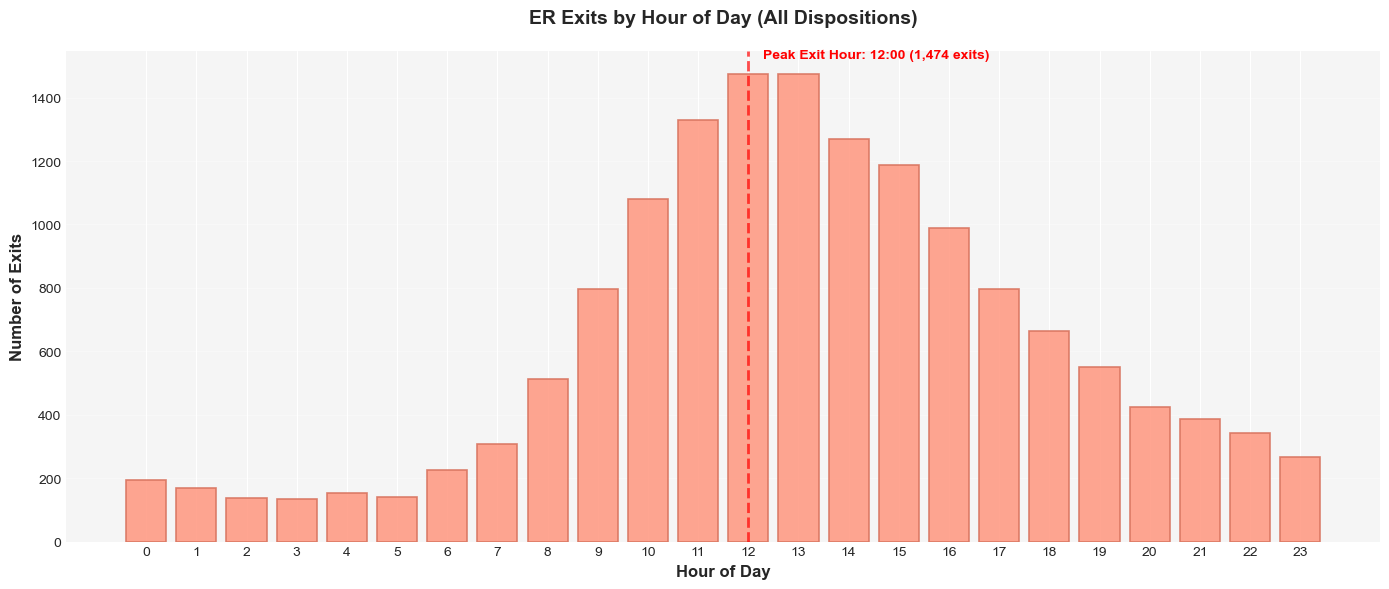


📊 Chart 1: ER Exits by Hour - Complete


In [19]:
# Visualization 1: ER Exits by Hour of Day
fig, ax = plt.subplots(figsize=(14, 6))

# Create bar chart
bars = ax.bar(exits_by_hour['exit_hour'], exits_by_hour['count'], 
               color='#FF9B85', edgecolor='#D97560', linewidth=1.2, alpha=0.9)

# Add peak hour indicator
peak_hour = int(peak_exit_hour['exit_hour'])
peak_count = int(peak_exit_hour['count'])
ax.axvline(x=peak_hour, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax.text(peak_hour + 0.3, peak_count + 50, 
        f'Peak Exit Hour: {peak_hour}:00 ({peak_count:,} exits)',
        fontsize=10, color='red', fontweight='bold')

# Formatting
ax.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Exits', fontsize=12, fontweight='bold')
ax.set_title('ER Exits by Hour of Day (All Dispositions)', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(range(0, 24))
ax.grid(True, alpha=0.3, axis='y')
ax.set_facecolor('#F5F5F5')

plt.tight_layout()
plt.show()

print("\n📊 Chart 1: ER Exits by Hour - Complete")

---
## Analysis 2: ER Arrivals by Hour of Day
Patient arrival patterns reveal:
- Demand surge periods
- Staffing requirement windows
- System intake pressure points

In [20]:
# Calculate arrivals by hour
arrivals_by_hour = df.groupby('arrival_hour').size().reset_index(name='count')
arrivals_by_hour = arrivals_by_hour.sort_values('arrival_hour')

# Find peak hour
peak_arrival_hour = arrivals_by_hour.loc[arrivals_by_hour['count'].idxmax()]

print(f"Peak Arrival Hour: {int(peak_arrival_hour['arrival_hour'])}:00 ({int(peak_arrival_hour['count']):,} arrivals)")
print(f"Total Arrivals Analyzed: {arrivals_by_hour['count'].sum():,}")

Peak Arrival Hour: 10:00 (1,538 arrivals)
Total Arrivals Analyzed: 15,000


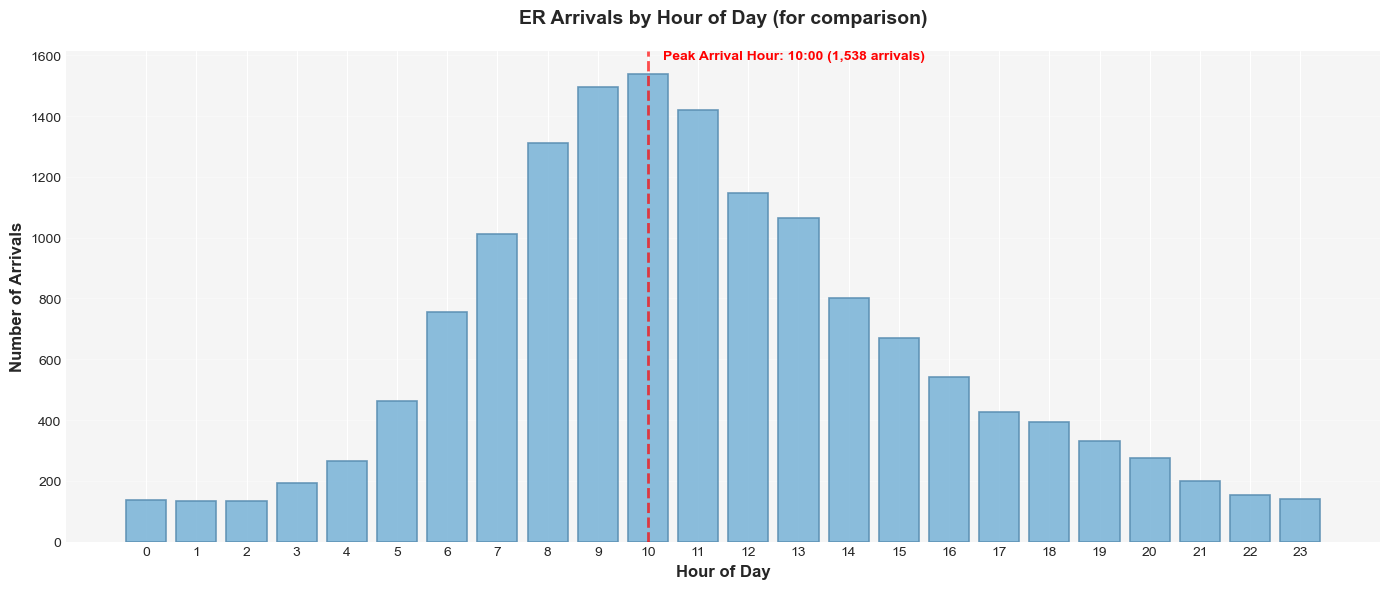


 Chart 2: ER Arrivals by Hour - Complete


In [21]:
# Visualization 2: ER Arrivals by Hour of Day
fig, ax = plt.subplots(figsize=(14, 6))

# Create bar chart
bars = ax.bar(arrivals_by_hour['arrival_hour'], arrivals_by_hour['count'], 
               color='#7EB6D9', edgecolor='#5B8FB3', linewidth=1.2, alpha=0.9)

# Add peak hour indicator
peak_hour = int(peak_arrival_hour['arrival_hour'])
peak_count = int(peak_arrival_hour['count'])
ax.axvline(x=peak_hour, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax.text(peak_hour + 0.3, peak_count + 50, 
        f'Peak Arrival Hour: {peak_hour}:00 ({peak_count:,} arrivals)',
        fontsize=10, color='red', fontweight='bold')

# Formatting
ax.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Arrivals', fontsize=12, fontweight='bold')
ax.set_title('ER Arrivals by Hour of Day (for comparison)', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(range(0, 24))
ax.grid(True, alpha=0.3, axis='y')
ax.set_facecolor('#F5F5F5')

plt.tight_layout()
plt.show()

print("\n Chart 2: ER Arrivals by Hour - Complete")

---
## Analysis 3: Arrivals vs Exits - System Flow Dynamics
Comparing arrivals and exits reveals:
- **Gap periods**: When arrivals exceed exits (system pressure)
- **Catchup periods**: When exits exceed arrivals (system recovery)
- **Critical bottleneck windows**: Where capacity constraints emerge

In [22]:
# Merge arrivals and exits data
flow_comparison = pd.merge(
    arrivals_by_hour.rename(columns={'count': 'arrivals'}),
    exits_by_hour.rename(columns={'count': 'exits', 'exit_hour': 'arrival_hour'}),
    on='arrival_hour',
    how='outer'
).fillna(0)

flow_comparison = flow_comparison.sort_values('arrival_hour')
flow_comparison['gap'] = flow_comparison['arrivals'] - flow_comparison['exits']
flow_comparison['cumulative_gap'] = flow_comparison['gap'].cumsum()

# Identify critical gap hours
critical_gaps = flow_comparison[flow_comparison['gap'] > 100].sort_values('gap', ascending=False)

print("\n Critical Gap Hours (Arrivals > Exits by >100):")
print(critical_gaps[['arrival_hour', 'arrivals', 'exits', 'gap']].to_string(index=False))


 Critical Gap Hours (Arrivals > Exits by >100):
 arrival_hour  arrivals  exits  gap
            8      1311    513  798
            7      1013    307  706
            9      1497    795  702
            6       755    227  528
           10      1538   1080  458
            5       464    140  324
            4       266    153  113


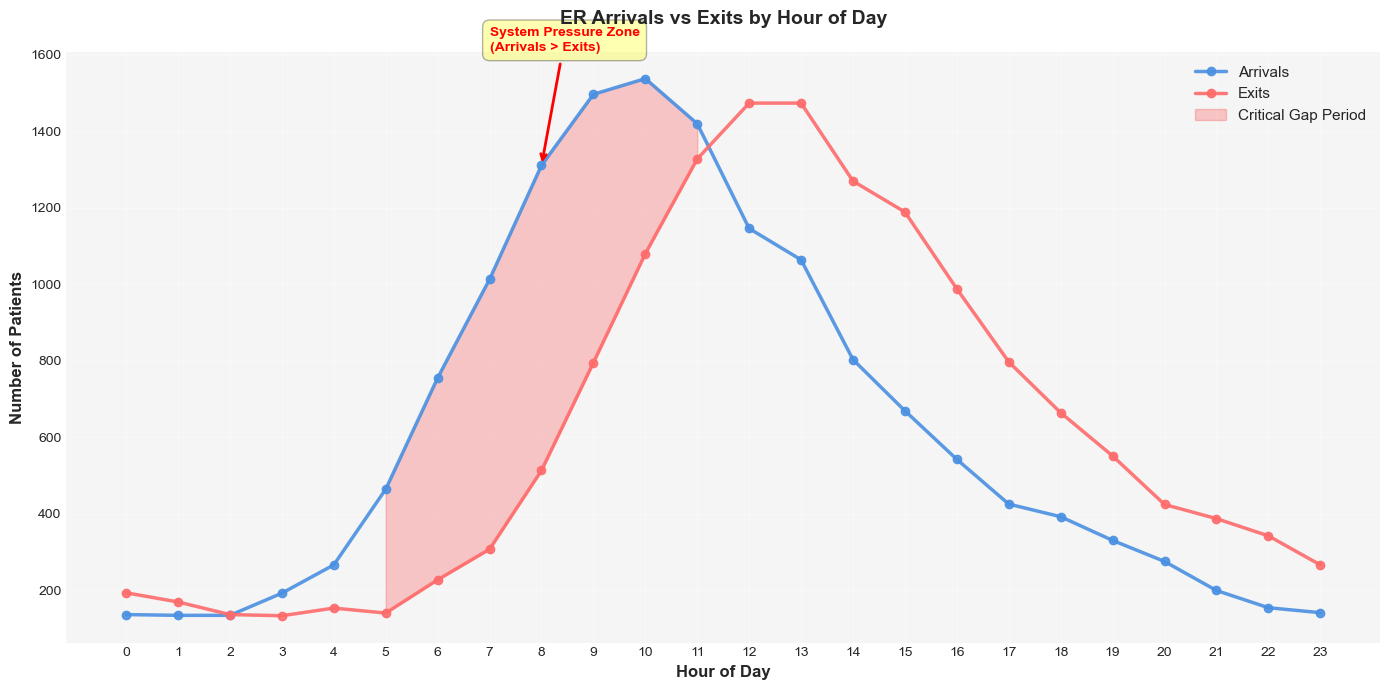


 Chart 3: Arrivals vs Exits Comparison - Complete


In [23]:
# Visualization 3: Arrivals vs Exits Line Chart with Gap Highlight
fig, ax = plt.subplots(figsize=(14, 7))

# Plot lines
ax.plot(flow_comparison['arrival_hour'], flow_comparison['arrivals'], 
        marker='o', linewidth=2.5, markersize=6, color='#4A90E2', 
        label='Arrivals', alpha=0.9)
ax.plot(flow_comparison['arrival_hour'], flow_comparison['exits'], 
        marker='o', linewidth=2.5, markersize=6, color='#FF6B6B', 
        label='Exits', alpha=0.9)

# Highlight gap area (hours 5-11 approximately)
gap_hours = flow_comparison[(flow_comparison['arrival_hour'] >= 5) & 
                            (flow_comparison['arrival_hour'] <= 11)]
if len(gap_hours) > 0:
    ax.fill_between(gap_hours['arrival_hour'], 
                     gap_hours['arrivals'], 
                     gap_hours['exits'],
                     alpha=0.2, color='red', 
                     label='Critical Gap Period')
    
    # Add gap annotation
    mid_gap_hour = int(gap_hours['arrival_hour'].median())
    mid_gap_value = gap_hours[gap_hours['arrival_hour'] == mid_gap_hour]['arrivals'].values[0]
    ax.annotate('System Pressure Zone\n(Arrivals > Exits)', 
                xy=(mid_gap_hour, mid_gap_value), 
                xytext=(mid_gap_hour - 1, mid_gap_value + 300),
                fontsize=10, fontweight='bold', color='red',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.3),
                arrowprops=dict(arrowstyle='->', color='red', lw=2))

# Formatting
ax.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Patients', fontsize=12, fontweight='bold')
ax.set_title('ER Arrivals vs Exits by Hour of Day', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(range(0, 24))
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', fontsize=11, framealpha=0.9)
ax.set_facecolor('#F5F5F5')

plt.tight_layout()
plt.show()

print("\n Chart 3: Arrivals vs Exits Comparison - Complete")

---
## Combined View: All Three Charts Stacked
Professional presentation with all visualizations in one figure

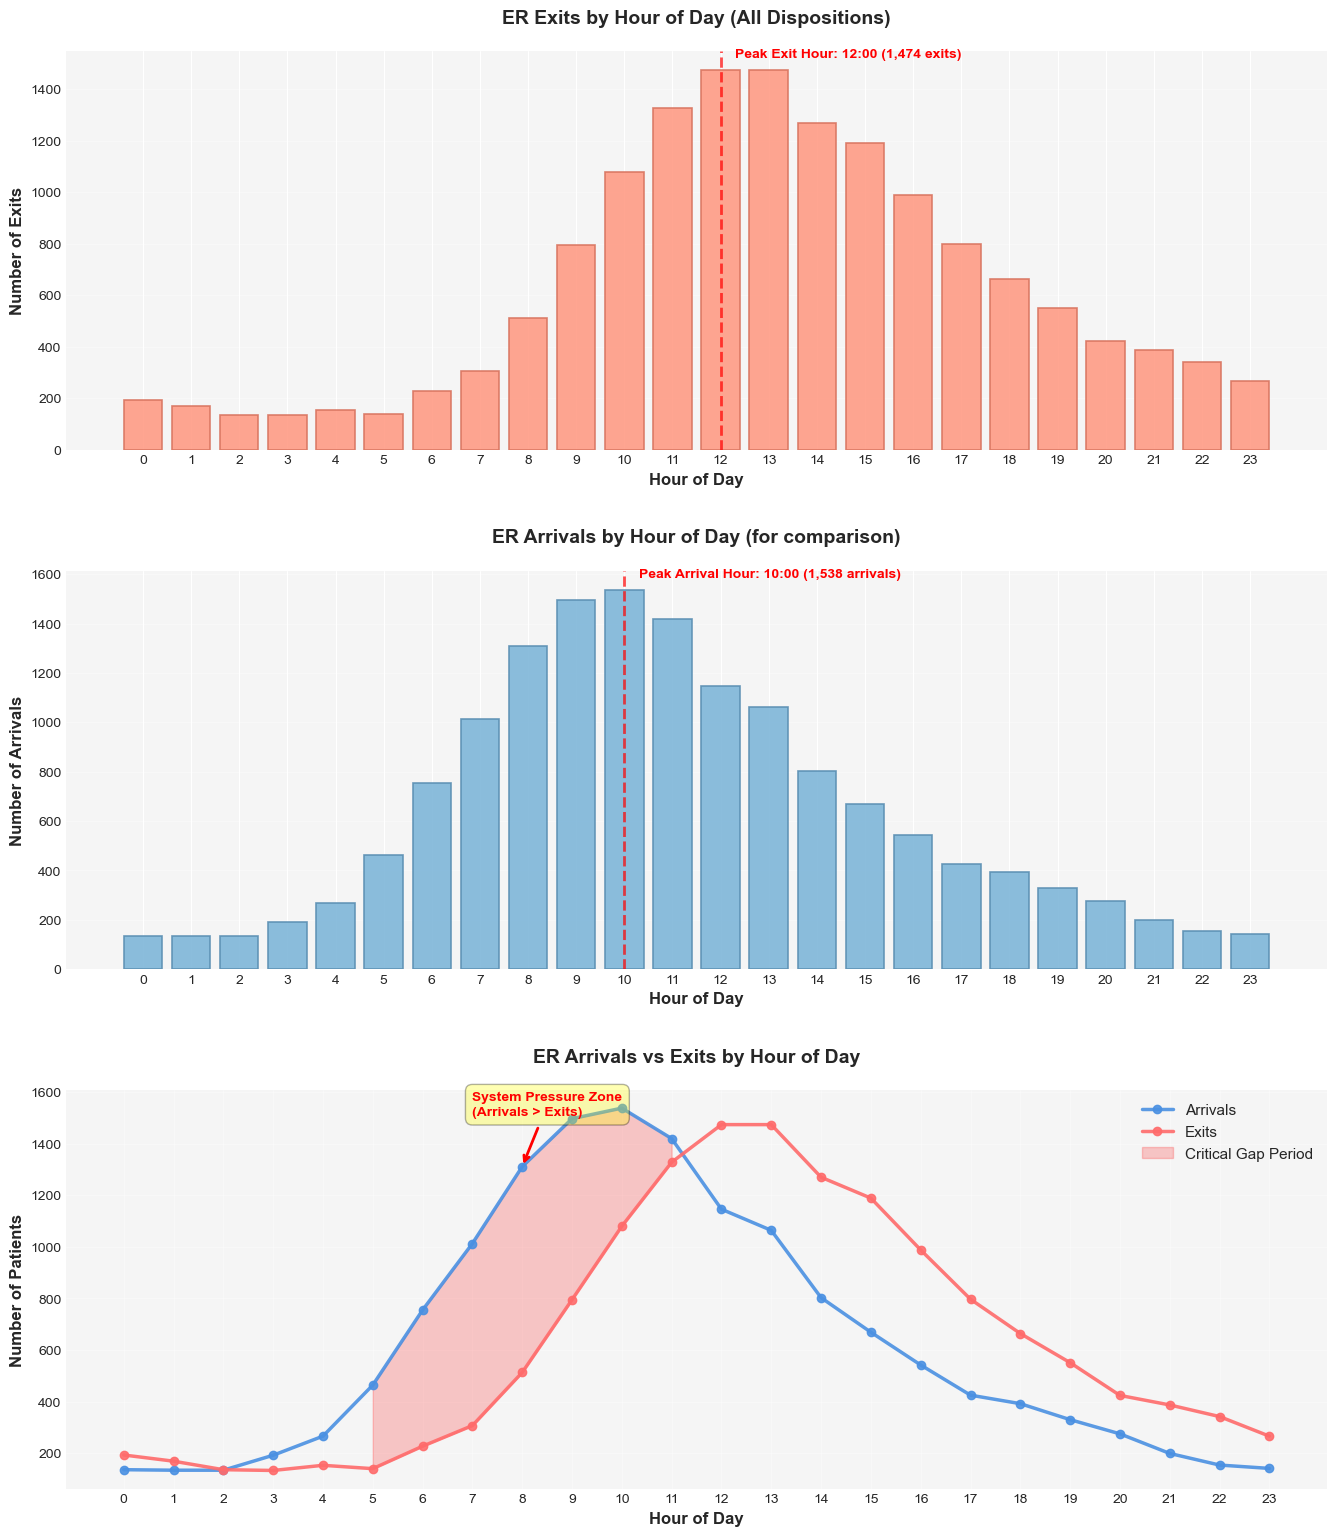


COMBINED VISUALIZATION COMPLETE


In [24]:
# Combined Visualization: All Three Charts Stacked Vertically
fig, axes = plt.subplots(3, 1, figsize=(14, 16))
fig.patch.set_facecolor('white')

# =====================================================================
# CHART 1: ER EXITS BY HOUR OF DAY
# =====================================================================
ax1 = axes[0]
bars1 = ax1.bar(exits_by_hour['exit_hour'], exits_by_hour['count'], 
                color='#FF9B85', edgecolor='#D97560', linewidth=1.2, alpha=0.9)

# Add peak hour indicator
peak_hour_exit = int(peak_exit_hour['exit_hour'])
peak_count_exit = int(peak_exit_hour['count'])
ax1.axvline(x=peak_hour_exit, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax1.text(peak_hour_exit + 0.3, peak_count_exit + 50, 
         f'Peak Exit Hour: {peak_hour_exit}:00 ({peak_count_exit:,} exits)',
         fontsize=10, color='red', fontweight='bold')

# Formatting
ax1.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Exits', fontsize=12, fontweight='bold')
ax1.set_title('ER Exits by Hour of Day (All Dispositions)', fontsize=14, fontweight='bold', pad=20)
ax1.set_xticks(range(0, 24))
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_facecolor('#F5F5F5')

# =====================================================================
# CHART 2: ER ARRIVALS BY HOUR OF DAY
# =====================================================================
ax2 = axes[1]
bars2 = ax2.bar(arrivals_by_hour['arrival_hour'], arrivals_by_hour['count'], 
                color='#7EB6D9', edgecolor='#5B8FB3', linewidth=1.2, alpha=0.9)

# Add peak hour indicator
peak_hour_arrival = int(peak_arrival_hour['arrival_hour'])
peak_count_arrival = int(peak_arrival_hour['count'])
ax2.axvline(x=peak_hour_arrival, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax2.text(peak_hour_arrival + 0.3, peak_count_arrival + 50, 
         f'Peak Arrival Hour: {peak_hour_arrival}:00 ({peak_count_arrival:,} arrivals)',
         fontsize=10, color='red', fontweight='bold')

# Formatting
ax2.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Arrivals', fontsize=12, fontweight='bold')
ax2.set_title('ER Arrivals by Hour of Day (for comparison)', fontsize=14, fontweight='bold', pad=20)
ax2.set_xticks(range(0, 24))
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_facecolor('#F5F5F5')

# =====================================================================
# CHART 3: ARRIVALS VS EXITS - LINE CHART WITH GAP
# =====================================================================
ax3 = axes[2]

# Plot lines
ax3.plot(flow_comparison['arrival_hour'], flow_comparison['arrivals'], 
         marker='o', linewidth=2.5, markersize=6, color='#4A90E2', 
         label='Arrivals', alpha=0.9)
ax3.plot(flow_comparison['arrival_hour'], flow_comparison['exits'], 
         marker='o', linewidth=2.5, markersize=6, color='#FF6B6B', 
         label='Exits', alpha=0.9)

# Highlight gap area (hours 5-11)
gap_hours = flow_comparison[(flow_comparison['arrival_hour'] >= 5) & 
                            (flow_comparison['arrival_hour'] <= 11)]
if len(gap_hours) > 0:
    ax3.fill_between(gap_hours['arrival_hour'], 
                     gap_hours['arrivals'], 
                     gap_hours['exits'],
                     alpha=0.2, color='red', 
                     label='Critical Gap Period')
    
    # Add gap annotation box
    mid_gap_hour = int(gap_hours['arrival_hour'].median())
    mid_gap_value = gap_hours[gap_hours['arrival_hour'] == mid_gap_hour]['arrivals'].values[0]
    ax3.annotate('System Pressure Zone\n(Arrivals > Exits)', 
                 xy=(mid_gap_hour, mid_gap_value), 
                 xytext=(mid_gap_hour - 1, mid_gap_value + 200),
                 fontsize=10, fontweight='bold', color='red',
                 bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.3),
                 arrowprops=dict(arrowstyle='->', color='red', lw=2))

# Formatting
ax3.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
ax3.set_ylabel('Number of Patients', fontsize=12, fontweight='bold')
ax3.set_title('ER Arrivals vs Exits by Hour of Day', fontsize=14, fontweight='bold', pad=20)
ax3.set_xticks(range(0, 24))
ax3.grid(True, alpha=0.3)
ax3.legend(loc='upper right', fontsize=11, framealpha=0.9)
ax3.set_facecolor('#F5F5F5')

# =====================================================================
# FINAL ADJUSTMENTS
# =====================================================================
plt.tight_layout(pad=3.0)
plt.show()

print("\n" + "="*70)
print("COMBINED VISUALIZATION COMPLETE")
print("="*70)


---
## Key Findings Summary

In [25]:
# Generate summary statistics
print("="*70)
print("KEY FINDINGS: ER HOURLY FLOW ANALYSIS")
print("="*70)

print(f"\n1️⃣  PEAK ARRIVAL HOUR: {int(peak_arrival_hour['arrival_hour'])}:00")
print(f"   - Volume: {int(peak_arrival_hour['count']):,} patients")
print(f"   - {(peak_arrival_hour['count'] / arrivals_by_hour['count'].sum() * 100):.1f}% of daily arrivals")

print(f"\n2️⃣  PEAK EXIT HOUR: {int(peak_exit_hour['exit_hour'])}:00")
print(f"   - Volume: {int(peak_exit_hour['count']):,} patients")
print(f"   - {(peak_exit_hour['count'] / exits_by_hour['count'].sum() * 100):.1f}% of daily exits")

print(f"\n3️⃣  CRITICAL GAP ANALYSIS:")
max_gap = flow_comparison.loc[flow_comparison['gap'].idxmax()]
print(f"   - Largest gap at hour {int(max_gap['arrival_hour'])}:00")
print(f"   - Gap size: {int(max_gap['gap']):,} patients (arrivals exceed exits)")
print(f"   - Peak cumulative backlog: {int(flow_comparison['cumulative_gap'].max()):,} patients")

print(f"\n4️⃣  OPERATIONAL INSIGHTS:")
morning_surge = flow_comparison[(flow_comparison['arrival_hour'] >= 5) & 
                                 (flow_comparison['arrival_hour'] <= 11)]['gap'].sum()
print(f"   - Morning surge gap (5am-11am): {int(morning_surge):,} patient accumulation")
print(f"   - Average arrivals per hour: {arrivals_by_hour['count'].mean():.0f}")
print(f"   - Average exits per hour: {exits_by_hour['count'].mean():.0f}")

print("\n" + "="*70)
print("Analysis complete! ✓")
print("="*70)

KEY FINDINGS: ER HOURLY FLOW ANALYSIS

1️⃣  PEAK ARRIVAL HOUR: 10:00
   - Volume: 1,538 patients
   - 10.3% of daily arrivals

2️⃣  PEAK EXIT HOUR: 12:00
   - Volume: 1,474 patients
   - 9.8% of daily exits

3️⃣  CRITICAL GAP ANALYSIS:
   - Largest gap at hour 8:00
   - Gap size: 798 patients (arrivals exceed exits)
   - Peak cumulative backlog: 3,686 patients

4️⃣  OPERATIONAL INSIGHTS:
   - Morning surge gap (5am-11am): 3,608 patient accumulation
   - Average arrivals per hour: 625
   - Average exits per hour: 625

Analysis complete! ✓


---
## Recommendations

Based on the hourly flow analysis:

### Immediate Actions
1. **Increase staffing during morning surge (5am-11am)** to handle the critical gap period
2. **Streamline discharge processes** during peak exit hours to improve throughput
3. **Implement fast-track protocols** during peak arrival times

### Strategic Improvements
1. **Predictive scheduling**: Align staff shifts with anticipated arrival patterns
2. **Process optimization**: Focus on reducing length of stay during gap hours
3. **Capacity planning**: Consider dynamic bed allocation based on time-of-day patterns

### Further Analysis Required
1. Breakdown by disposition type to understand different patient flow patterns
2. Severity level analysis to prioritize critical cases during surge periods
3. Day-of-week patterns to identify additional variation